# Step 1: Defining the Study Area

In [1]:
import geopandas as gpd

# Load the Morocco shapefile from the ZIP
morocco = gpd.read_file(
    r"C:\Users\abdel\OneDrive\Desktop\PFE_Project\Data\Raw\GIS\Study_Area_Boundary\morocco.zip"
)

# Check the first few rows to see province names
morocco.head()

,OBJECTID,LAYER,GM_TYPE,NumCom,Code,CodeCommun,CommuneMun,CommuneGro,CodeCercle,Cercle,...,SupMapHa,SupMapKm2,Densite204,TxAccAnn94,SAU,Shape_Leng,Shape_Area,Pop2004,Pop1994,geometry
0,1,CUrb,Unknown Area Type,101,1630103,3,AIT BAHA (M),Ait Baha,1,None,...,289.0,2.89,1649.48,2.74,196,6649.301032,2.895962e+06,4767,3638,"POLYGON ((500064.146 590485.31, 500724.22 5901..."


<Axes: >

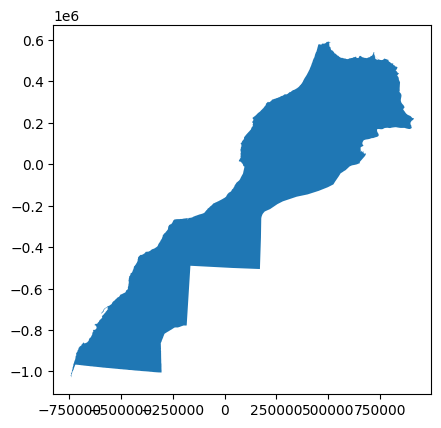

In [2]:
morocco.plot()

In [3]:
# Replace with the path to your shapefile
shp_path =r"C:\Users\abdel\OneDrive\Desktop\PFE_Project\Data\Raw\GIS\Study_Area_Boundary\Tadla_plain\Tadla_plain.shp"

# Read the shapefile into a GeoDataFrame
tadla = gpd.read_file(shp_path)

# Check the data
print(tadla)  # Show first few rows


   CC_2 GID_0     GID_1       GID_2    HASC_2        NAME_1  NAME_2    TYPE_2  \
0    81   MAR  MAR.13_1  MAR.13.1_1  MA.TD.AZ  Tadla-Azilal  Azilal  Province   

   COUNTRY ENGTYPE_2 NL_NAME_1 NL_NAME_2 VARNAME_2  \
0  Morocco  Province        NA        NA        NA   

                                            geometry  
0  POLYGON ((-7.1668 31.6115, -7.1781 31.6119, -7...  


In [4]:
tadla.columns # List all columns

Index(['CC_2', 'GID_0', 'GID_1', 'GID_2', 'HASC_2', 'NAME_1', 'NAME_2',
       'TYPE_2', 'COUNTRY', 'ENGTYPE_2', 'NL_NAME_1', 'NL_NAME_2', 'VARNAME_2',
       'geometry'],
      dtype='object')

<Axes: >

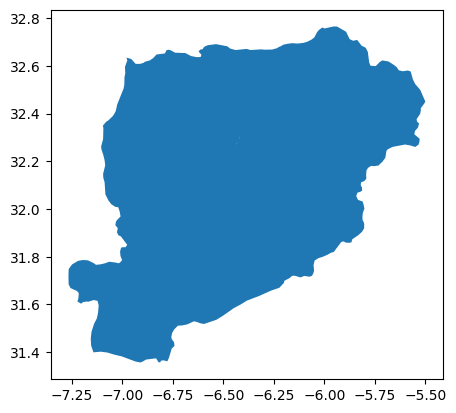

In [5]:
tadla.plot()  # Plot the geometry

In [6]:
print(f"Study area size: {tadla.geometry.area} m²")  # Should be ~1.2M hectares (Tadla's approximate size)

Study area size: 0    1.488719
dtype: float64 m²


C:\Users\abdel\AppData\Local\Temp\ipykernel_21596\2566919686.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Study area size: {tadla.geometry.area} m²")  # Should be ~1.2M hectares (Tadla's approximate size)


In [7]:
# Reproject to Merchich (EPSG:26191)
tadla_merchiche = tadla.to_crs(epsg=26191)

# Calculate area
area_m2 = tadla_merchiche.geometry.area
print(f"Study area size: {area_m2[0]:.2f} m²")  
# Example output: "Study area size: 1300000000.00 m²"

area_ha = area_m2 / 10000
print(f"Study area size: {area_ha[0]:.2f} hectares")  
# Example output: "Study area size: 130000.00 hectares"


Study area size: 15573013765.35 m²
Study area size: 1557301.38 hectares


<Axes: >

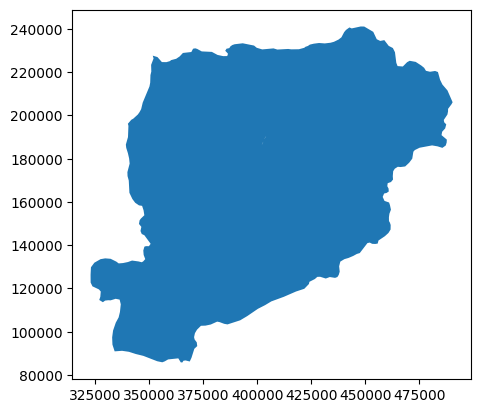

In [8]:
tadla_merchiche.plot()

In [9]:
# Load the cleaned boundary shapefile
tadla_plain_polygone = gpd.read_file("C:/Users/abdel/OneDrive/Desktop/PFE_Project/Data/Raw/GIS/Study_Area_Boundary/Tadla_plain_boundary/Tadla_plain_boundary.shp")

# Check the current CRS
print(tadla_plain_polygone.crs)

EPSG:4326


In [10]:
# Convert to Merchich CRS if needed
if tadla_plain_polygone.crs != "EPSG:26191":
    tadla_plain_polygone = tadla_plain_polygone.to_crs(epsg=26191)


<Axes: >

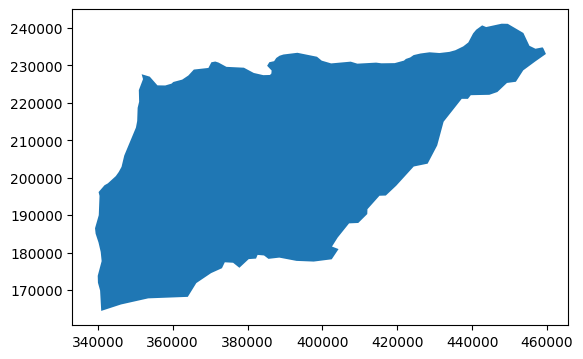

In [11]:
tadla_plain_polygone.plot()

In [ ]:
# Assume these are already loaded and in the same CRS (EPSG:26191)
# tadla_merchiche: full administrative boundary (Merchich)
# tadla_plain_polygone: digitized Tadla plain (which may be slightly off)

# Compute the common (intersecting) area between the two layers
tadla_plain = gpd.overlay(tadla_plain_polygone, tadla_merchiche, how='intersection')

# Save the resulting common area shapefile for further analysis
tadla_plain.to_file("C:/Users/abdel/OneDrive/Desktop/PFE_Project/Data/Processed/GIS/Study_Area_Boundary/Tadla_plain_common.shp")

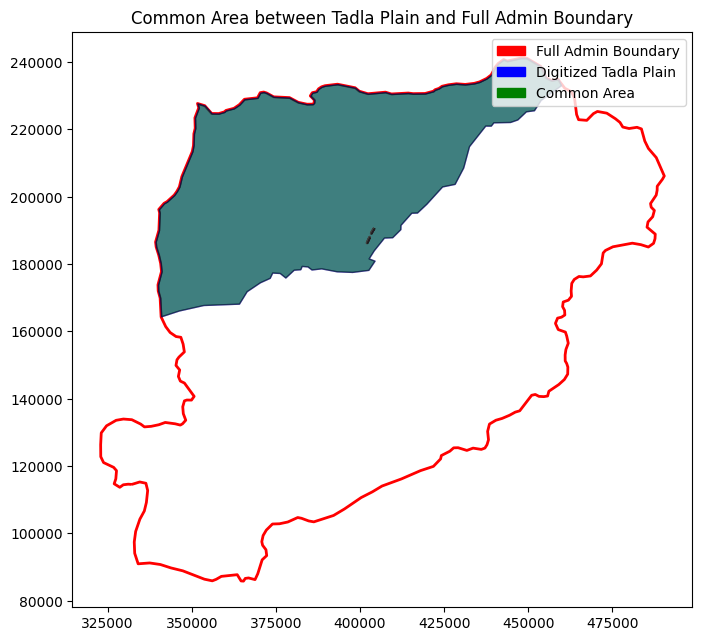

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Plot layers with explicit labels
fig, ax = plt.subplots(figsize=(8, 8))
tadla_merchiche.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)
tadla_plain_polygone.plot(ax=ax, facecolor="blue", alpha=0.5, edgecolor="blue")
tadla_plain.plot(ax=ax, facecolor="green", alpha=0.5, edgecolor="black")

# Create custom legend
legend_labels = {
    "Full Admin Boundary": "red",
    "Digitized Tadla Plain": "blue",
    "Common Area": "green"
}
patches = [Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=patches)

plt.title("Common Area between Tadla Plain and Full Admin Boundary")
plt.show()

In [14]:
tadla_plain = tadla_plain.to_crs(epsg=26191)  # Ensure projection
tadla_merchiche = tadla_merchiche.to_crs(epsg=26191)

area_plain_m2 = tadla_plain.geometry.area.sum()
area_full_m2 = tadla_merchiche.geometry.area.sum()

print(f"Tadla Plain area: {area_plain_m2:.2f} m²")
print(f"Full Admin Boundary area: {area_full_m2:.2f} m²")


Tadla Plain area: 4653651925.89 m²
Full Admin Boundary area: 15573013765.35 m²


In [15]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject

def reproject_raster(input_path, output_path, target_crs):
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )
        metadata = src.meta.copy()
        metadata.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        with rasterio.open(output_path, "w", **metadata) as dest:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dest, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs
            )

# Step 2: Downloading Soil Data (SoilGrids)

In [ ]:
import geopandas as gpd

# Load Tadla boundary (EPSG:26191)
tadla = gpd.read_file(r"C:\Users\abdel\OneDrive\Desktop\PFE_Project\Data\Processed\GIS\Study_Area_Boundary\tadla_plain_common.shp")
tadla = tadla.to_crs("EPSG:26191")

# Get bounding box in Merchich coordinates
minx, miny, maxx, maxy = tadla.total_bounds
print(f"X: {minx}, {maxx}")  # Easting bounds
print(f"Y: {miny}, {maxy}")  # Northing bounds

X: 339269.02644034184, 459699.2928407953
Y: 164445.30748250836, 241159.59764125413


### 1. Defining Parameters

In [31]:
# Bounding box of Tadla Plain in EPSG:26191 (from your URL)
minx, maxx = 339200, 459750  # X (Easting)
miny, maxy = 164400, 241200  # Y (Northing)

# Soil layers and their COVERAGEIDs (adjust if needed)
layers = {
    "clay": "clay_0-5cm_mean",
    "silt": "silt_0-5cm_mean",
    "sand": "sand_0-5cm_mean",
    "ocd": "ocd_0-5cm_mean",    # Organic carbon density
    "wcs": "wcs_0-5cm_mean"     # Water content at saturation
}

### 2. Python Script to Download All Layers

In [32]:
import requests
import os

# Output directory
soil_raw_dir = r"C:\Users\abdel\OneDrive\Desktop\PFE_Project\Data\Raw\GIS\Soil"
os.makedirs(soil_raw_dir, exist_ok=True)

for param, coverage_id in layers.items():
    url = (
        f"https://maps.isric.org/mapserv?map=/map/{param}.map&"
        f"SERVICE=WCS&"
        f"VERSION=2.0.1&"
        f"REQUEST=GetCoverage&"
        f"COVERAGEID={coverage_id}&"
        f"FORMAT=GEOTIFF_INT16&"  # Or GEOTIFF_FLOAT32 for raw values
        f"SUBSET=X({minx},{maxx})&"
        f"SUBSET=Y({miny},{maxy})&"
        f"SUBSETTINGCRS=http://www.opengis.net/def/crs/EPSG/0/26191&"
        f"OUTPUTCRS=http://www.opengis.net/def/crs/EPSG/0/26191"
    )
    
    # Download and save
    response = requests.get(url)
    if response.status_code == 200:
        output_path = os.path.join(soil_raw_dir, f"tadla_{param}.tif")
        with open(output_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded {param} to {output_path}")
    else:
        print(f"Failed to download {param}: HTTP {response.status_code}")

Downloaded clay to C:\Users\abdel\OneDrive\Desktop\PFE_Project\Data\Raw\GIS\Soil\tadla_clay.tif
Downloaded silt to C:\Users\abdel\OneDrive\Desktop\PFE_Project\Data\Raw\GIS\Soil\tadla_silt.tif
Downloaded sand to C:\Users\abdel\OneDrive\Desktop\PFE_Project\Data\Raw\GIS\Soil\tadla_sand.tif
Downloaded ocd to C:\Users\abdel\OneDrive\Desktop\PFE_Project\Data\Raw\GIS\Soil\tadla_ocd.tif
Downloaded wcs to C:\Users\abdel\OneDrive\Desktop\PFE_Project\Data\Raw\GIS\Soil\tadla_wcs.tif


### 3. Post-Processing

1. Unit Conversion:

    SoilGrids stores integer values as actual value × 10. 
    
    For example:
        A pixel value of 150 = 15% clay.

In [1]:
import rasterio
import numpy as np

with rasterio.open("C:/Users/abdel/OneDrive/Desktop/PFE_Project/Data/Raw/GIS/Soil/tadla_clay.tif") as src:
    clay = src.read(1)
    clay = clay.astype(np.float32) / 10  # Convert to %
    profile = src.profile.copy()
    profile.update(dtype=rasterio.float32)

    with rasterio.open("C:/Users/abdel/OneDrive/Desktop/PFE_Project/Data/Processed/GIS/Soiltadla_clay_processed.tif", "w", **profile) as dst:
        dst.write(clay, 1)

2. Validate CRS Alignment

    Confirm all downloaded rasters are in EPSG:26191

In [37]:
import rasterio

with rasterio.open("C:/Users/abdel/OneDrive/Desktop/PFE_Project/Data/Raw/GIS/Soil/tadla_clay.tif") as src:
    print(src.crs)  # Should print "EPSG:26191"

EPSG:26191
